In [1]:
from pulp import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def bakery():
    input_filename = "bakey.txt"
    f = open(input_filename, "r")   
    data1 = []
    for t in f:
        data1.append(t.split())
    for list in data1:
        for i in range(len(list)):
            list[i] = int(list[i])   
    data = np.array(data1)
    
    start = LpVariable.dicts("s",[i for i in range(len(data))], lowBound=0)
    x = LpVariable.dicts("x", [(i,j) for i in range(len(data)) for j in range(len(data))], cat=LpBinary)
    obj = LpVariable("end_last_pastry", lowBound=0)
    M = max(row[2] for row in data) + 1000

    prob = LpProblem("problem", LpMinimize)
    prob += obj

    for i in range(len(data)):
        prob += start[data[i][0]] >= data[i][1] 
        prob += start[data[i][0]] <= data[i][2] - data[i][3]
       
    for i in range(len(data)):
        for j in range(len(data)):
            if j != i:
                
                prob += start[data[i][0]] <= start[data[j][0]] - data[i][3] + M *x[i,j]
                prob += start[data[j][0]] <= start[data[i][0]] - data[j][3] + M*(1-x[i,j])

    for i in range(len(data)):
        prob += obj >= start[data[i][0]] + data[i][3]
    prob.solve(PULP_CBC_CMD(msg = 0))
    print("Optimal value:", value(prob.objective))
    #for i in range(len(data)):
    #    print("Pastry", i, "should start baking at time", value(start[i]))
    f.close()
    starts = []
    
    for i in range(17):
        starts.append(value(start[i]))
    return starts
    
bakery()




Optimal value: 22200.0


[9000.0,
 19800.0,
 0.0,
 4800.0,
 1800.0,
 9600.0,
 12000.0,
 10800.0,
 7800.0,
 600.0,
 15000.0,
 18000.0,
 16200.0,
 20400.0,
 13200.0,
 5400.0,
 2400.0]

Optimal value: 22200.0


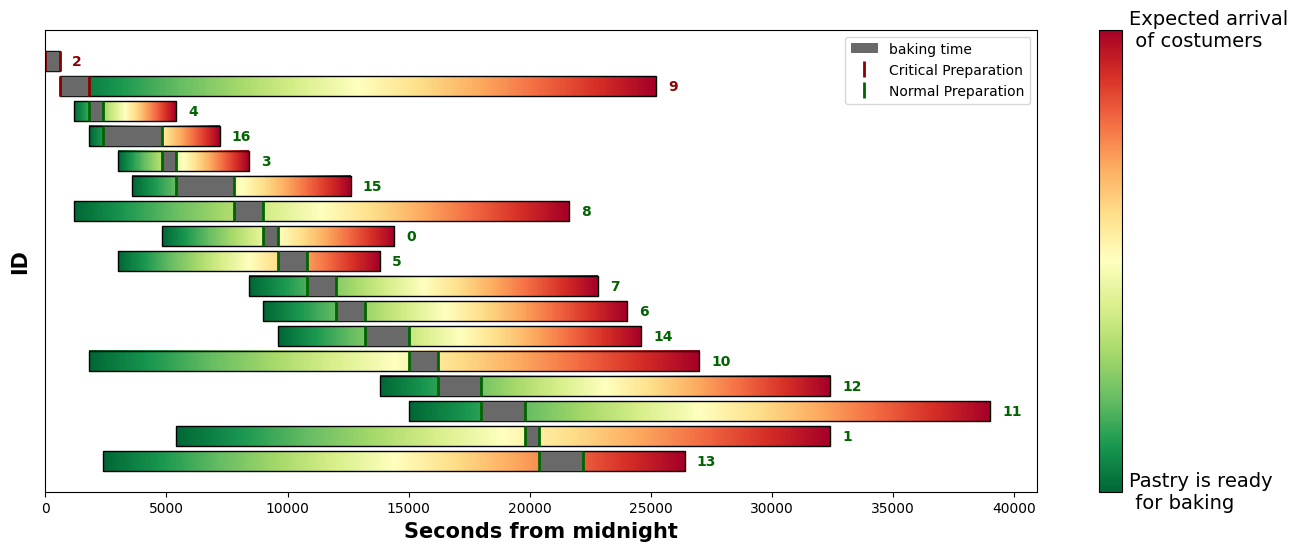

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch



def visual():
    input_filename = "bakey.txt"
    f = open(input_filename, "r")   
    data1 = []
    for t in f:
        data1.append(t.split())
    for list in data1:
        for i in range(len(list)):
            list[i] = int(list[i])  
    data = pd.DataFrame(data1, columns=["ID", "PRE", "DLN", "BAK"])
    data["start_time"] = bakery()
    s_data = data.sort_values("start_time", ascending=False)
    #print(s_data)

    ind = np.arange(len(s_data))
    def gradientbars(bars):
      
        ax = bars[0].axes
        lim = ax.get_xlim()+ax.get_ylim()
        for bar in bars:
          
            bar.set_zorder(1)
            bar.set_facecolor("none")
            x,y = bar.get_xy()
            w, h = bar.get_width(), bar.get_height()
            grad = np.atleast_2d(np.linspace(0,1,1000))
            im = ax.imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0, norm=mpl.colors.NoNorm(vmin=0,vmax=1), cmap = plt.get_cmap("RdYlGn_r"))
            
        ax.axis(lim)  
        return im
    fig, ax = plt.subplots(figsize=(16,6))
    ax.yaxis.set_ticks_position('none') # removes the tick marks on the y-axis but leaves the text

    ax.set_yticklabels([])
    ax.set_ylabel("ID", fontsize = 15, fontweight = "bold")
    ax.set_xlabel("Seconds from midnight", fontsize = 15, fontweight = "bold")
  

    
    bars = []
  
    for i, (v, j, k, st, et) in enumerate(zip(s_data.ID, s_data.PRE, s_data.DLN, s_data.start_time, s_data.start_time + s_data.BAK)):
        
        bars.append( ax.barh(i, k, left=j, edgecolor="black"))

        ax.hlines(i, st, et, color = "#696969", linewidth = 14)
        
        if st== j:
            
            ax.text(j + k + 500, i, str(v), color='#8B0000', fontweight='bold', ha='left', va="center" )
            ax.vlines(x=et, ymin=i-0.4, ymax=i+0.4, color='#8B0000', linewidth=2)
            ax.vlines(x=st, ymin=i-0.4, ymax=i+0.4, color='#8B0000', linewidth=2)
        else:
            ax.text(j + k + 500, i, str(v), color='#006400', fontweight='bold', ha='left', va='center')
            ax.vlines(x=et, ymin=i-0.4, ymax=i+0.4, color='#006400', linewidth=2)
            ax.vlines(x=st, ymin=i-0.4, ymax=i+0.4, color=	"#006400", linewidth=2)
        
        

    
    for bar in bars:
        gradientbars(bar)

    im = gradientbars(bar)  # get the mappable for the colorbar
    
    cbar = fig.colorbar(im, ax=ax)

    cbar.ax.yaxis.set_ticks_position("none") # removes the tick marks on the y-axis but leaves the text
    cbar.ax.set_yticklabels([])
    ax.text(1.3, -0.000001, 'Pastry is ready \n for baking', ha='left', va='center', transform=cbar.ax.transAxes, fontsize=14)
    ax.text(1.3, 1.000001, 'Expected arrival \n of costumers', ha='left', va='center', transform=cbar.ax.transAxes, fontsize=14)
    
   
    bt1 = mpatches.Patch(facecolor='#696969', label='baking time', linewidth=2, edgecolor='none')
    crit  = mlines.Line2D([], [], color='#8B0000', label='Critical Preparation', linestyle = "none", marker="|", markersize = 12, markeredgewidth = 2)
    norm  = mlines.Line2D([], [], color='#006400', label="Normal Preparation", linestyle = "none", marker="|", markersize = 12, markeredgewidth = 2)
   
    
    plt.legend(handles=[bt1, crit,norm])
 
    plt.show()
visual()

    
